# Federated Learning Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Model Definition

We'll create a simple CNN with 2 convolutional layers and 2 dense layers.

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, image_size=28):
        super(SimpleCNN, self).__init__()
        self.image_size = image_size
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten_size = self._get_conv_output_size(input_channels)

        self.dense_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def _get_conv_output_size(self, input_channels):
        x = torch.randn(1, input_channels, self.image_size, self.image_size)
        x = self.conv_layers(x)
        return x.flatten().shape[0]

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flatten_size)
        x = self.dense_layers(x)
        return x

## Data Loading and Processing

We'll load either MNIST or CIFAR-10 and split it into two non-overlapping subsets.

In [3]:
def load_and_split_data(dataset_name='mnist', n_points=600) -> Tuple[List[Dataset], Dataset]:
    if dataset_name.lower() == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_dataset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(
            root='./data', train=False, download=True, transform=transform)
        input_channels = 1
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform)
        input_channels = 3

    indices = torch.randperm(len(train_dataset))
    subset1_idx = indices[:n_points]
    subset2_idx = indices[n_points:2*n_points]

    subset1 = Subset(train_dataset, subset1_idx)
    subset2 = Subset(train_dataset, subset2_idx)

    return [subset1, subset2], test_dataset, input_channels

train_datasets, test_dataset, input_channels = load_and_split_data('mnist', 600)
print(f"Number of samples in each client's dataset: {len(train_datasets[0])}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of samples in each client's dataset: 600
Number of samples in test dataset: 10000


In [4]:
def get_model_parameters(model: nn.Module) -> List[torch.Tensor]:
    return [param.data.clone() for param in model.parameters()]

def set_model_parameters(model: nn.Module, parameters: List[torch.Tensor]):
    for param, new_param in zip(model.parameters(), parameters):
        param.data.copy_(new_param)

def average_model_parameters(models_parameters: List[List[torch.Tensor]],
                           weights: List[float]) -> List[torch.Tensor]:
    avg_parameters = []
    for param_set in zip(*models_parameters):
        avg_param = sum(w * p for w, p in zip(weights, param_set))
        avg_parameters.append(avg_param)
    return avg_parameters

## Training and Evaluation Functions

In [33]:
def train_client(model: nn.Module,
                train_loader: DataLoader,
                epochs: int,
                device: torch.device) -> float:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    return running_loss / len(train_loader)

def evaluate_model(model: nn.Module,
                  test_loader: DataLoader,
                  device: torch.device) -> Tuple[float, float]:
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    return avg_loss, accuracy

## Federated Training Implementation

In [45]:
def federated_training(models: List[nn.Module],
                      train_datasets: List[Dataset],
                      test_loader: DataLoader,
                      device: torch.device,
                      local_epochs: int = 5,
                      num_rounds: int = 10,
                      averaging_weights: List[float] = None,
                      batch_size=50) -> List[dict]:
    if averaging_weights is None:
        averaging_weights = [1/len(models)] * len(models)

    train_loaders = [DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)
                    for ds in train_datasets]
    history = []

    for round_num in range(num_rounds):
        print(f"\nRound {round_num + 1}/{num_rounds}")

        round_losses = []
        for i, (model, train_loader) in enumerate(zip(models, train_loaders)):
            loss = train_client(model, train_loader, local_epochs, device)
            round_losses.append(loss)
            print(f"Client {i+1} loss: {loss:.4f}")

        models_parameters = [get_model_parameters(model) for model in models]
        averaged_parameters = average_model_parameters(models_parameters,
                                                    averaging_weights)

        for model in models:
            set_model_parameters(model, averaged_parameters)

        test_loss, test_acc = evaluate_model(models[0], test_loader, device)
        print(f"Global model - Test loss: {test_loss:.4f}, "
              f"Test accuracy: {test_acc:.2f}%")

        history.append({
            'round_losses': round_losses,
            'test_loss': test_loss,
            'test_accuracy': test_acc
        })

    return history

## Run the Experiment

In [7]:
models = [
    SimpleCNN(input_channels=input_channels).to(device)
    for _ in range(2)
]

initial_parameters = get_model_parameters(models[0])
set_model_parameters(models[1], initial_parameters)

test_loader = DataLoader(test_dataset, batch_size=50)

history = federated_training(
    models=models,
    train_datasets=train_datasets,
    test_loader=test_loader,
    device=device,
    local_epochs=5,
    num_rounds=10,
    averaging_weights=[0.5, 0.5]
)


Round 1/10
Client 1 loss: 0.3176
Client 2 loss: 0.2693
Global model - Test loss: 0.4603, Test accuracy: 85.87%

Round 2/10
Client 1 loss: 0.0656
Client 2 loss: 0.0548
Global model - Test loss: 0.2076, Test accuracy: 94.10%

Round 3/10
Client 1 loss: 0.0243
Client 2 loss: 0.0181
Global model - Test loss: 0.1828, Test accuracy: 94.95%

Round 4/10
Client 1 loss: 0.0115
Client 2 loss: 0.0071
Global model - Test loss: 0.1617, Test accuracy: 95.75%

Round 5/10
Client 1 loss: 0.0084
Client 2 loss: 0.0039
Global model - Test loss: 0.1619, Test accuracy: 95.75%

Round 6/10
Client 1 loss: 0.0075
Client 2 loss: 0.0033
Global model - Test loss: 0.1546, Test accuracy: 95.88%

Round 7/10
Client 1 loss: 0.0014
Client 2 loss: 0.0083
Global model - Test loss: 0.1702, Test accuracy: 96.10%

Round 8/10
Client 1 loss: 0.0104
Client 2 loss: 0.0008
Global model - Test loss: 0.1755, Test accuracy: 96.11%

Round 9/10
Client 1 loss: 0.0005
Client 2 loss: 0.0008
Global model - Test loss: 0.1700, Test accuracy:

## Visualize Results

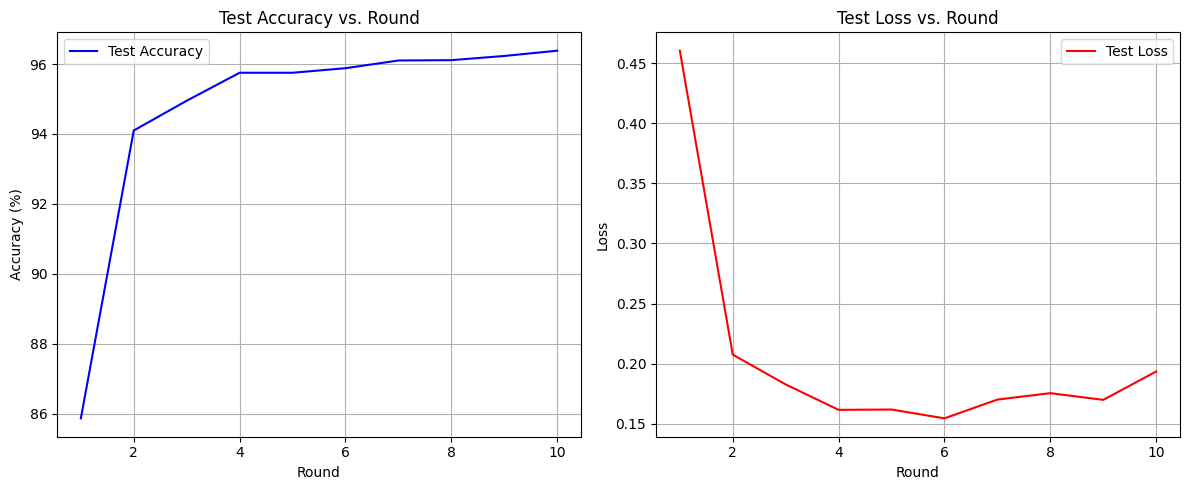

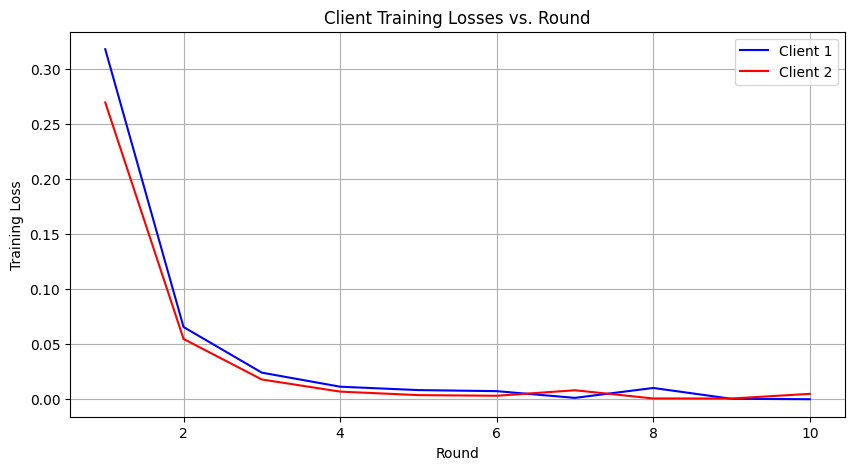

In [8]:
rounds = range(1, len(history) + 1)
test_accuracies = [h['test_accuracy'] for h in history]
test_losses = [h['test_loss'] for h in history]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rounds, test_accuracies, 'b-', label='Test Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Round')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, test_losses, 'r-', label='Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Test Loss vs. Round')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
client1_losses = [h['round_losses'][0] for h in history]
client2_losses = [h['round_losses'][1] for h in history]

plt.plot(rounds, client1_losses, 'b-', label='Client 1')
plt.plot(rounds, client2_losses, 'r-', label='Client 2')
plt.xlabel('Round')
plt.ylabel('Training Loss')
plt.title('Client Training Losses vs. Round')
plt.grid(True)
plt.legend()
plt.show()

## Experiment with Different Number of data points

In [53]:
def n_point_study(dataset_name='mnist', n_points=[50, 150, 300, 600]):
    results = []

    for n_point in n_points:
        print(f"\nTesting n_point: {n_point}")

        train_datasets, test_dataset, input_channels = load_and_split_data(
            dataset_name, n_point)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        models = [
            SimpleCNN(input_channels=input_channels, image_size=(28if dataset_name=='mnist' else 32)).to(device)
            for _ in range(2)
        ]

        initial_parameters = get_model_parameters(models[0])
        set_model_parameters(models[1], initial_parameters)

        history = federated_training(
            models=models,
            train_datasets=train_datasets,
            test_loader=test_loader,
            device=device,
            local_epochs=5,
            num_rounds=10,
            averaging_weights=[0.5, 0.5],
            batch_size=50
        )

        results.append({
            'n_points': n_point,
            'history': history
        })

    return results

n_point_results = n_point_study(n_points=[50, 150, 300, 600])


Testing n_point: 50

Round 1/10
Client 1 loss: 1.8699
Client 2 loss: 1.7090
Global model - Test loss: 2.0663, Test accuracy: 21.65%

Round 2/10
Client 1 loss: 1.0753
Client 2 loss: 1.2919
Global model - Test loss: 1.4289, Test accuracy: 63.13%

Round 3/10
Client 1 loss: 0.5686
Client 2 loss: 0.7732
Global model - Test loss: 0.9932, Test accuracy: 72.33%

Round 4/10
Client 1 loss: 0.3446
Client 2 loss: 0.5005
Global model - Test loss: 0.9119, Test accuracy: 70.52%

Round 5/10
Client 1 loss: 0.2956
Client 2 loss: 0.3512
Global model - Test loss: 0.8081, Test accuracy: 74.67%

Round 6/10
Client 1 loss: 0.1028
Client 2 loss: 0.2394
Global model - Test loss: 0.7245, Test accuracy: 76.74%

Round 7/10
Client 1 loss: 0.0839
Client 2 loss: 0.1920
Global model - Test loss: 0.7277, Test accuracy: 77.34%

Round 8/10
Client 1 loss: 0.0619
Client 2 loss: 0.1020
Global model - Test loss: 0.7348, Test accuracy: 77.22%

Round 9/10
Client 1 loss: 0.0293
Client 2 loss: 0.0614
Global model - Test loss: 0

## Visualize Different Number of data points results

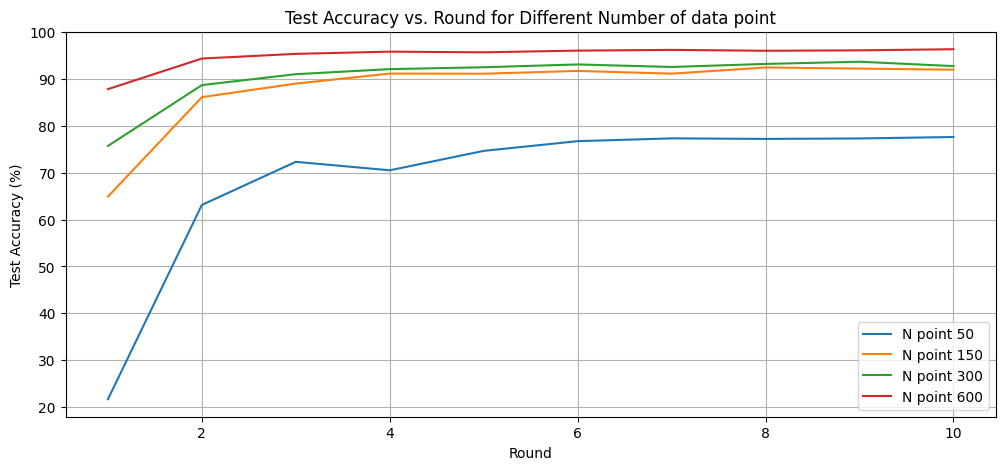

In [57]:
plt.figure(figsize=(12, 5))

for result in n_point_results:
    n_point = result['n_points']
    accuracies = [h['test_accuracy'] for h in result['history']]
    plt.plot(rounds, accuracies, label=f'N point {n_point}')

plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Round for Different Number of data point')
plt.grid(True)
plt.legend()
plt.show()


The minimum number of data points necessary for acceptable performance (>90%) is approximately 150

# Try CIFAR-10 Dataset

In [35]:
train_datasets, test_dataset, input_channels = load_and_split_data('cifar10', 600)
test_loader = DataLoader(test_dataset, batch_size=50)

models = [
    SimpleCNN(input_channels=input_channels, image_size=32).to(device)
    for _ in range(2)
]

initial_parameters = get_model_parameters(models[0])
set_model_parameters(models[1], initial_parameters)

cifar_history = federated_training(
    models=models,
    train_datasets=train_datasets,
    test_loader=test_loader,
    device=device,
    local_epochs=5,
    num_rounds=10,
    averaging_weights=[0.5, 0.5],
)

Files already downloaded and verified
Files already downloaded and verified

Round 1/10
Client 1 loss: 1.6250
Client 2 loss: 1.6501
Global model - Test loss: 1.9878, Test accuracy: 30.48%

Round 2/10
Client 1 loss: 1.2741
Client 2 loss: 1.2343
Global model - Test loss: 1.7158, Test accuracy: 37.53%

Round 3/10
Client 1 loss: 1.0037
Client 2 loss: 0.9877
Global model - Test loss: 1.7516, Test accuracy: 40.37%

Round 4/10
Client 1 loss: 0.8057
Client 2 loss: 0.7360
Global model - Test loss: 1.7624, Test accuracy: 41.71%

Round 5/10
Client 1 loss: 0.5800
Client 2 loss: 0.5265
Global model - Test loss: 1.8517, Test accuracy: 42.00%

Round 6/10
Client 1 loss: 0.4047
Client 2 loss: 0.3547
Global model - Test loss: 2.0150, Test accuracy: 43.00%

Round 7/10
Client 1 loss: 0.2622
Client 2 loss: 0.2078
Global model - Test loss: 2.1785, Test accuracy: 42.84%

Round 8/10
Client 1 loss: 0.1473
Client 2 loss: 0.1177
Global model - Test loss: 2.4392, Test accuracy: 42.60%

Round 9/10
Client 1 loss: 0

## Experiment with Different Number of data points

In [58]:
cifar_n_point_results = n_point_study(dataset_name='cifar10', n_points=[50, 150, 300, 600])


Testing n_point: 50
Files already downloaded and verified
Files already downloaded and verified

Round 1/10
Client 1 loss: 2.0848
Client 2 loss: 2.0440
Global model - Test loss: 2.3660, Test accuracy: 14.74%

Round 2/10
Client 1 loss: 1.8514
Client 2 loss: 1.7353
Global model - Test loss: 2.2714, Test accuracy: 19.40%

Round 3/10
Client 1 loss: 1.5193
Client 2 loss: 1.3723
Global model - Test loss: 2.2954, Test accuracy: 21.23%

Round 4/10
Client 1 loss: 1.2937
Client 2 loss: 1.0624
Global model - Test loss: 2.3447, Test accuracy: 21.94%

Round 5/10
Client 1 loss: 1.1073
Client 2 loss: 0.8198
Global model - Test loss: 2.4022, Test accuracy: 22.63%

Round 6/10
Client 1 loss: 0.9145
Client 2 loss: 0.6143
Global model - Test loss: 2.5571, Test accuracy: 23.12%

Round 7/10
Client 1 loss: 0.7369
Client 2 loss: 0.4320
Global model - Test loss: 2.7825, Test accuracy: 23.76%

Round 8/10
Client 1 loss: 0.5404
Client 2 loss: 0.3811
Global model - Test loss: 2.8138, Test accuracy: 24.28%

Round 

## Visualize Different Number of data points results

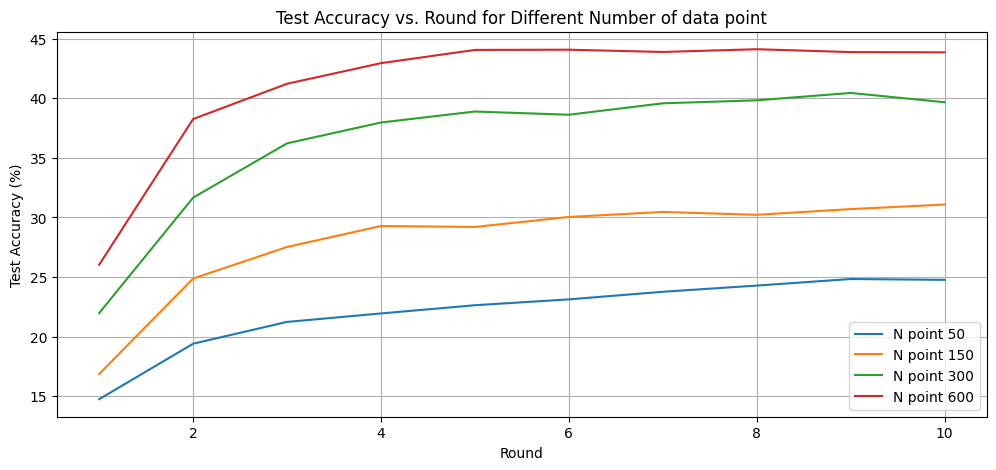

In [59]:
plt.figure(figsize=(12, 5))

for result in cifar_n_point_results:
    n_point = result['n_points']
    accuracies = [h['test_accuracy'] for h in result['history']]
    plt.plot(rounds, accuracies, label=f'N point {n_point}')

plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Round for Different Number of data point')
plt.grid(True)
plt.legend()
plt.show()
